In [2]:
import torch
import os
import sys
import pickle
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd
from numpy import var
import warnings

In [3]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
def k_means_identify(X_trainn, X_testt, Y_trainn, Y_testt, word):
    # Collect data on model faults and mispredictions : Logistic Regression
    # Scale the inputs to have zero mean and unit variance
    scaler = StandardScaler()
    reg_model = LogisticRegression(max_iter=1000)
    reg_model.fit(scaler.fit_transform(X_trainn), Y_trainn)

    # Predict the target variable for the testing set
    Y_pred = reg_model.predict(scaler.fit_transform(X_testt))
    accuracy = accuracy_score(Y_testt, Y_pred)
    precision = precision_score(Y_testt, Y_pred)
    recall = recall_score(Y_testt, Y_pred)
    f1 = f1_score(Y_testt, Y_pred)
    print('Logistic Regression before changes: accuracy, precision, recall, f1: ', accuracy, precision, recall, f1)

    # Identify the mispredictions and their associated feature values
    data_test = X_testt.copy()
    data_test[word] = Y_testt
    data_test['Prediction'] = Y_pred
    mispredictions = data_test[data_test[word] != data_test['Prediction']]

    # Use the elbow method to determine the optimal number of clusters
    mispredictions_array = mispredictions.drop([word, 'Prediction'], axis=1).values
    distortions = []
    for n_clusters in range(2, 20):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
        kmeans.fit(mispredictions_array)
        distortions.append(kmeans.inertia_)

    # Select the optimal number of clusters based on the elbow method
    best_n_clusters = 0
    best_distortion = float('inf')
    for i in range(len(distortions) - 1):
        if abs(distortions[i] - distortions[i + 1]) < best_distortion:
            best_n_clusters = i + 2
            best_distortion = abs(distortions[i] - distortions[i + 1])

    # Use the optimal number of clusters determined by the elbow method
    n_clusters = best_n_clusters
    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}

    # Use k-means clustering to identify groups of similar customers
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(mispredictions.drop([word, 'Prediction'], axis=1))

    # Use SelectKBest to identify the important features
    for i in range(n_clusters):
        cluster_data = mispredictions[clusters == i].drop([word, 'Prediction'], axis=1)
        X = cluster_data.values
        Y = data_test[data_test[word] != data_test['Prediction']][word][clusters == i]

        # Remove constant features
        constant_features = [j for j, column in enumerate(X.T) if var(column) == 0]
        X = np.delete(X, constant_features, axis=1)
        cluster_data = cluster_data.drop(cluster_data.columns[constant_features], axis=1)
        if X.shape[1] == 0:
            print("All features are constant in this cluster")
        else:
            selector = SelectKBest(f_classif, k=1)
            selector = selector.fit(X, Y)
            mask = selector.get_support()
            important_features = cluster_data.columns[mask]

            # Make changes to the predictive model by removing the least important features
            X_train_new = X_trainn.drop(important_features, axis=1)
            X_test_new = X_testt.drop(important_features, axis=1)
            model_new = LogisticRegression(max_iter=1000)
            model_new.fit(scaler.fit_transform(X_train_new), Y_trainn)
            Y_pred_new = model_new.predict(scaler.fit_transform(X_test_new))
            accuracy_new = accuracy_score(Y_testt, Y_pred_new)
            accuracy_dict.update({i: accuracy_new})
            precision_new = precision_score(Y_testt, Y_pred_new)
            precision_dict.update({i: precision_new})
            recall_new = recall_score(Y_testt, Y_pred_new)
            recall_dict.update({i: recall_new})
            f1_new = f1_score(Y_testt, Y_pred_new)
            f1_dict.update({i: f1_new})
    max_accuracy = max(accuracy_dict.values())
    print('The max accuracy we could get is', max_accuracy)
    max_precision = max(precision_dict.values())
    print('The max precision we could get is', max_precision)
    max_recall = max(recall_dict.values())
    print('The max recall we could get is', max_recall)
    max_f = max(f1_dict.values())
    print('The max f1 we could get is', max_f)
    print('We gain a better accuracy of the model of', (max_accuracy - accuracy) * 100, '%')
    print('We gain a better precision of the model of', (max_precision - precision) * 100, '%')
    print('We gain a better recall of the model of', (max_recall - recall) * 100, '%')
    print('We gain a better f1 score of the model of', (max_f - f1) * 100, '%')

In [5]:
def py_optimize_neural(X_tr, X_te, Y_tr, Y_te):
    # Use PyTorch to optimize the model parameters and improve the accuracy of the predictions
    num_epochs = 100
    learning_rate = 0.01
    input_size = X_tr.shape[1]
    hidden_size = 10
    output_size = 1

    # Scale the inputs to have zero mean and unit variance
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.fit_transform(X_te)

    # Convert the data to PyTorch tensors
    X_tr = torch.tensor(X_tr, dtype=torch.float32)
    Y_tr = torch.tensor(Y_tr.values, dtype=torch.float32)
    X_te = torch.tensor(X_te, dtype=torch.float32)
    Y_te = torch.tensor(Y_te.values, dtype=torch.float32)
    model = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, output_size),
        torch.nn.Sigmoid()
    )
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_tr)
        Y_tr = Y_tr.view(-1, 1)
        loss = criterion(outputs, Y_tr)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Use the trained model to make predictions on the test set
    test_outputs = model(X_te)
    Y_te = Y_te.view(-1, 1)

    # Evaluate the performance of the model using accuracy and other metrics
    test_predictions = (test_outputs.detach().numpy() > 0.5).astype(int)
    test_actuals = Y_te.detach().numpy().astype(int)
    accuracy = accuracy_score(test_actuals, test_predictions)
    precision = precision_score(test_actuals, test_predictions, zero_division=1)
    recall = recall_score(test_actuals, test_predictions)
    f1 = f1_score(test_actuals, test_predictions)
    print(
        'Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 score: {:.3f}'.format(accuracy, precision, recall, f1))

    # Create a bar plot of the evaluation metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    values = [accuracy, precision, recall, f1]
    plt.bar(metrics, values)
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Value')
    plt.show()

    # Calculate the confusion matrix
    cm = confusion_matrix(test_actuals, test_predictions)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.yticks([0, 1], ['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_actuals, test_outputs.detach().numpy())
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
def py_different_model(X_trainn, Y_trainn):
    # Define the pipelines for the different models to be compared
    pipelines = {
        'lr': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))]),
        'rf': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())]),
        'svc': Pipeline([('scaler', StandardScaler()), ('clf', SVC())])
    }

    # Define the hyperparameters for the different models
    hyperparameters = {
        'lr': {'clf__C': [0.1, 1.0, 10.0]},
        'rf': {'clf__n_estimators': [10, 100, 1000]},
        'svc': {'clf__C': [0.1, 1.0, 10.0], 'clf__kernel': ['linear', 'rbf']}
    }

    # Use PyTorch to compare the performance of the different models using cross-validation
    num_folds = 5
    results = {}
    """for model_name, pipeline in pipelines.items():
        clf = GridSearchCV(pipeline, hyperparameters[model_name], cv=num_folds, scoring='accuracy')
        clf.fit(X_train, Y_train)
        results[model_name] = clf.best_score_

    # Select the best model based on the cross-validation results
    best_model = max(results, key=results.get)
    print('Best model:', best_model)"""
    for model_name, pipeline in pipelines.items():
        clf = GridSearchCV(pipeline, hyperparameters[model_name], cv=num_folds, scoring='accuracy')
        clf.fit(X_trainn, Y_trainn)
        results[model_name] = {
            'best_score': clf.best_score_,
            'best_params': clf.best_params_,
            'cv_results': clf.cv_results_
        }

    # Print the results for each model
    for model_name, result in results.items():
        print('Model:', model_name)
        print('Best score:', result['best_score'])
        print('Best params:', result['best_params'])
        print()

    # Visualize the accuracy of the different models
    model_names = list(results.keys())
    model_scores = [result['best_score'] for result in results.values()]
    plt.bar(model_names, model_scores)
    plt.title('Accuracy of Different Models')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.show()

In [7]:
def py_visualization(X_trainn, X_testt, Y_trainn, Y_testt):
    # Logistic Regression
    # Scale the inputs to have zero mean and unit variance
    scaler = StandardScaler()
    reg_model = LogisticRegression(max_iter=1000)
    reg_model.fit(scaler.fit_transform(X_trainn), Y_trainn)

    # Predict the target variable for the testing set
    Y_pred = reg_model.predict(scaler.fit_transform(X_testt))
    # Convert the predictions and actual outcomes to PyTorch tensors
    Y_pred_torch = torch.tensor(Y_pred, dtype=torch.float32)
    Y_test_torch = torch.tensor(Y_testt.values, dtype=torch.float32)

    # Plot the distribution of model predictions and actual outcomes, histogram plot
    plt.hist(Y_pred_torch.detach().numpy(), bins=20, alpha=0.5, label='Predictions')
    plt.hist(Y_test_torch, bins=20, alpha=0.5, label='Actual Outcomes')
    plt.legend(loc='upper right')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

    # Plot the distribution of predictions and actual outcomes, kernel density estimate plot
    sns.kdeplot(Y_pred_torch.numpy(), label='Predictions')
    sns.kdeplot(Y_test_torch.numpy(), label='Actual Outcomes')
    plt.title('Distribution of Predictions and Actual Outcomes')
    plt.xlabel('Outcome')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Company Bankrupt Dataset

In [10]:
# Load the company bankrupt dataset into dataframe.
bankrupt_df = pd.read_csv('../data/raw/company_bankruptcy.csv')
    
X_bankrupt = bankrupt_df.drop(["Bankrupt?"], axis=1)
Y_bankrupt = bankrupt_df["Bankrupt?"]

over_sample = SMOTE()
X_ros_bankrupt, Y_ros_bankrupt = over_sample.fit_resample(X_bankrupt, Y_bankrupt)

# we split the data into training and testing sets
X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt = train_test_split(X_ros_bankrupt, Y_ros_bankrupt, test_size=0.2, random_state=42)

In [13]:
k_means_identify(X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt, "Bankrupt?")

Logistic Regression before changes: accuracy, precision, recall, f1:  0.8924242424242425 0.8906727828746177 0.8920367534456355 0.891354246365723
The max accuracy we could get is 0.8977272727272727
The max precision we could get is 0.8942161339421614
The max recall we could get is 0.8996937212863706
The max f1 we could get is 0.8969465648854962
We gain a better accuracy of the model of 0.5303030303030254 %
We gain a better precision of the model of 0.3543351067543665 %
We gain a better recall of the model of 0.7656967840735107 %
We gain a better f1 score of the model of 0.5592318519773154 %


Accuracy: 0.919, Precision: 0.902, Recall: 0.939, F1 score: 0.920


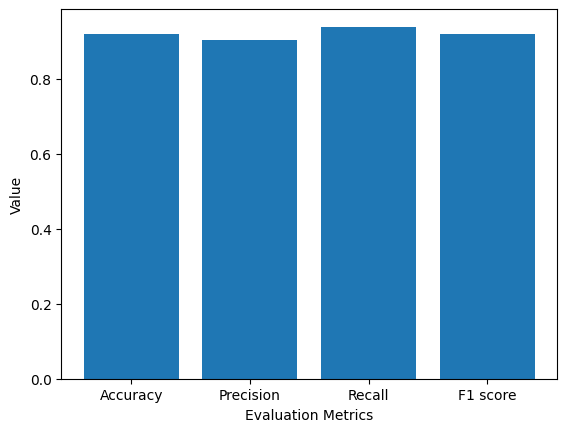

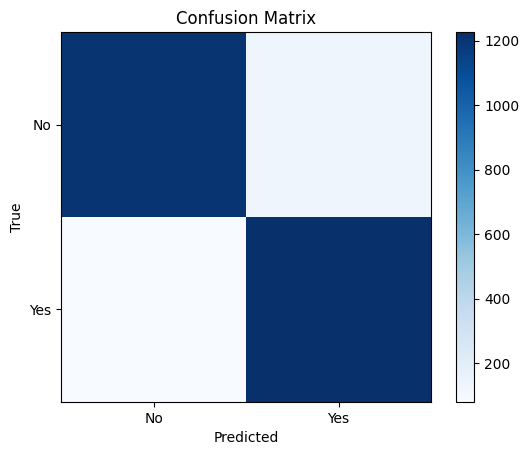

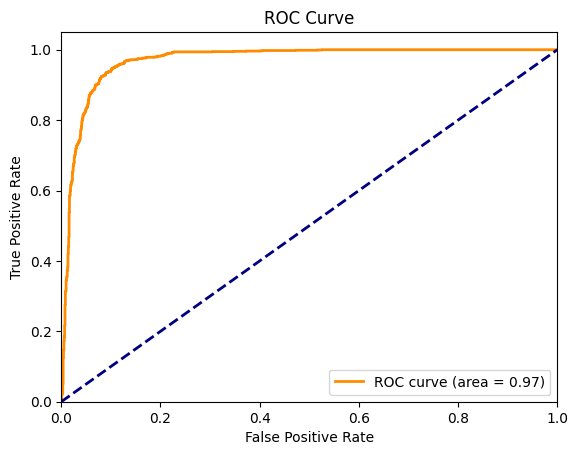

In [14]:
py_optimize_neural(X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt)

In [ ]:
py_different_model(X_train_bankrupt, Y_train_bankrupt)

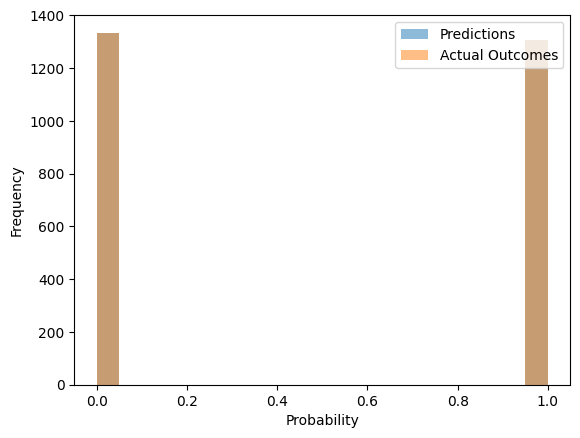

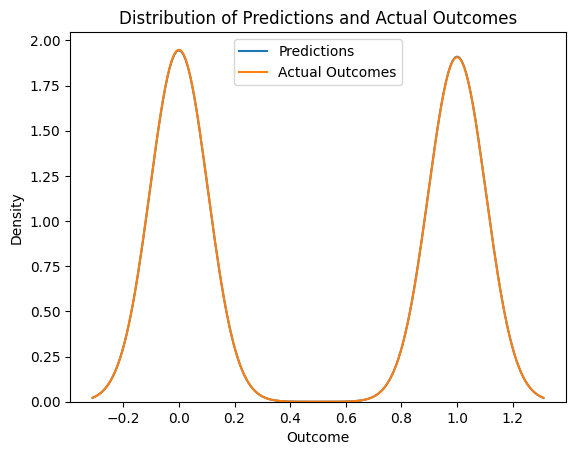

In [11]:
py_visualization(X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt)